In [4]:
import pandas as pd
import networkx as nx
import ast
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np


In [5]:
from ogb.graphproppred import GraphPropPredDataset

dataset = GraphPropPredDataset(name = "ogbg-molpcba")

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

graph, label = dataset[349519] 

c:\Users\20203071\AppData\Local\Programs\Python\Python39\lib\site-packages\ogb\graphproppred\dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch

In [6]:
edge_index = graph['edge_index']
num_nodes = graph['num_nodes']
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)

In [7]:
results = pd.read_csv('subgroups_graph_349519.csv')

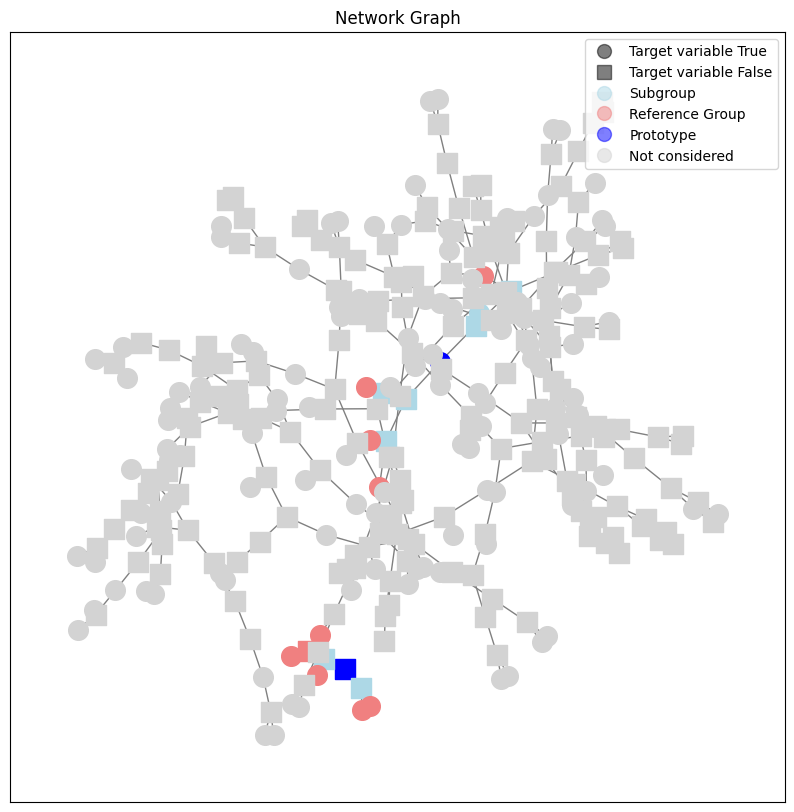

In [11]:
# Correct one for multiple

prototypes = [46, 11]

reference_groups = {
    46: [46, 44, 47, 45, 42, 49, 48, 41, 43],
    11: [11, 12, 8, 6, 13, 9, 14, 5, 19, 7, 10]
}
subgroups = {
    46: [46, 44, 47],
    11: [11, 12, 8, 6, 13, 9, 14]
}

def get_node_status(node, prototype):
    index_prototype = results[results['Unnamed: 0'] == prototype].index[0]
    ranks_list = ast.literal_eval(results['ranks'][index_prototype])
    for rank_node, status in ranks_list:
        if rank_node == node:
            return status

prototype_nodes_true = []
prototype_nodes_false = []
subgroup_nodes_true = []
subgroup_nodes_false = []
reference_group_nodes_true = []
reference_group_nodes_false = []
therest_nodes = set(G.nodes())

for prototype in prototypes:
    prototype_nodes = [node for node in G.nodes() if node == prototype]
    prototype_nodes_true.extend([node for node in prototype_nodes if get_node_status(node, prototype)])
    prototype_nodes_false.extend([node for node in prototype_nodes if not get_node_status(node, prototype)])

    subgroup_nodes = [node for node in subgroups[prototype] if node != prototype]
    subgroup_nodes_true.extend([node for node in subgroup_nodes if get_node_status(node, prototype)])
    subgroup_nodes_false.extend([node for node in subgroup_nodes if not get_node_status(node, prototype)])

    reference_group_nodes = [node for node in reference_groups[prototype] if node not in subgroups[prototype] and node != prototype]
    reference_group_nodes_true.extend([node for node in reference_group_nodes if get_node_status(node, prototype)])
    reference_group_nodes_false.extend([node for node in reference_group_nodes if not get_node_status(node, prototype)])

    therest_nodes -= set(reference_groups[prototype])
    therest_nodes -= set([prototype])

therest_group_nodes_true = [node for node in therest_nodes if get_node_status(node, prototype)]
therest_group_nodes_false = [node for node in therest_nodes if not get_node_status(node, prototype)]

plt.figure(figsize=(10, 10))
position = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos=position, edge_color='gray')

nx.draw_networkx_nodes(G, pos=position, nodelist=prototype_nodes_true, node_color='blue', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=prototype_nodes_false, node_color='blue', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=subgroup_nodes_true, node_color='lightblue', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=subgroup_nodes_false, node_color='lightblue', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=reference_group_nodes_true, node_color='lightcoral', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=reference_group_nodes_false, node_color='lightcoral', node_shape='s', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=therest_group_nodes_true, node_color='lightgray', node_shape='o', node_size=200)
nx.draw_networkx_nodes(G, pos=position, nodelist=therest_group_nodes_false, node_color='lightgray', node_shape='s', node_size=200)

plt.title("Network Graph")

circle_marker = Line2D([0], [0], marker='o', color='black', label='Target variable True', markersize=10, linestyle='None', markerfacecolor='black', alpha=0.5)
square_marker = Line2D([0], [0], marker='s', color='black', label='Target variable False', markersize=10, linestyle='None', markerfacecolor='black', alpha=0.5)

prototype_marker = Line2D([0], [0], marker='o', color='blue', label='Prototype', markersize=10, linestyle='None', markerfacecolor='blue', alpha=0.5)
subgroup_marker = Line2D([0], [0], marker='o', color='lightblue', label='Subgroup', markersize=10, linestyle='None', markerfacecolor='lightblue', alpha=0.5)
reference_marker = Line2D([0], [0], marker='o', color='lightcoral', label='Reference Group', markersize=10, linestyle='None', markerfacecolor='lightcoral', alpha=0.5)
therest_marker = Line2D([0], [0], marker='o', color='lightgray', label='Not considered', markersize=10, linestyle='None', markerfacecolor='lightgray', alpha=0.5)

plt.legend(handles=[circle_marker, square_marker, subgroup_marker, reference_marker, prototype_marker, therest_marker], loc='upper right')

plt.show()